In [36]:
import sys
import os
import psycopg2
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
import unicodedata
import string
import numpy as np
import spacy    
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()
import matplotlib.pyplot as plt

Loading BokehJS ...

In [37]:
def retrieve_reviews(product):
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' and product_name = '{}'".format(product))
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df

def retrieve_all_reviews():
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' ")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df



In [38]:
#df = retrieve_reviews('LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model)')
df = retrieve_all_reviews()

In [39]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,475,Samsung Electronics UN65MU6300 65-Inch 4K Ultr...,https://www.amazon.com/Samsung-Electronics-UN6...,1,1,5.0 out of 5 stars,"August 28, 2017",James Barrow,Someone here complained that the television is...,"Before I purchased this television, I read alm...",Verified Purchase Helpful No...,Samsung,tv,UN65MU6300
1,504,Samsung Electronics UN65MU6300 65-Inch 4K Ultr...,https://www.amazon.com/Samsung-Electronics-UN6...,3,30,5.0 out of 5 stars,"June 25, 2017",Alex C. Tarpenning,"This is a great tv, after all","This is a great tv, after all, its a Samsung. ...",Verified Purchase Helpful No...,Samsung,tv,UN65MU6300


In [40]:
columns = ['id','p_name','url','p_no','r_no','r_stars','r_date','r_name','r_title','r_text','r_comments','category','brand_name','model']
df.columns = columns
df.groupby(['r_stars']).count()
df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x == '5.0 out of 5 stars' else 0)
df_new = df_new[['rating','r_name','r_text']]
df_new.head(3)

,rating,r_name,r_text
0,1,James Barrow,"Before I purchased this television, I read alm..."
1,1,Alex C. Tarpenning,"This is a great tv, after all, its a Samsung. ..."
2,0,Alexis Mcphee,"Samsung is throwing the term ""Smart"" around ve..."


In [41]:
nlp = spacy.load("en")
document = df_new.iloc[3]['r_text']
parsed_document = nlp(document)

for num, sentence in enumerate(parsed_document.sents):
    print (num, sentence)

0 Remote stops working after day 1 it seems there is an issue with the bt module, support doesn’t work there are tons of complains cuse it’s stops working after firmware update.
1 Now i have a very expensive tv not working as it should’ve.
2 Google smart remote not working not aviabale message.
3 Bad for Samsung


In [42]:
for num, entity in enumerate(parsed_document.ents):
    print (entity, entity.label_)
token_text = [token.orth_ for token in parsed_document]
token_pos = [token.pos_ for token in parsed_document]
token_tag = [token.tag_ for token in parsed_document]

token_lemma = [token.lemma_ for token in parsed_document]
token_shape = [token.shape_ for token in parsed_document]
token_prob = [token.prob for token in parsed_document]

Google ORG
Samsung ORG


In [43]:
df_spicy = pd.DataFrame({'token_text':token_text, 'token_lemma':token_lemma, 'token_pos':token_pos,'token_prob':token_prob, 'token_tag':token_tag})

df_spicy

,token_lemma,token_pos,token_prob,token_tag,token_text
0,remote,NOUN,-13.536487,NN,Remote
1,stop,VERB,-10.718275,VBZ,stops
2,work,VERB,-8.447863,VBG,working
3,after,ADP,-7.265652,IN,after
4,day,NOUN,-7.400947,NN,day
5,1,NUM,-7.639833,CD,1
6,it,PRON,-4.388050,PRP,it
7,seem,VERB,-7.989145,VBZ,seems
8,there,ADV,-6.135282,EX,there
9,be,VERB,-4.457749,VBZ,is


In [44]:
stop_words = set(stopwords.words('english'))

def punct_space(token):
    return token.is_punct or token.is_space

def is_stop_word(token):
    return token in stop_words

def is_noun(token):
    return token.pos_ in ['NOUN','ADJ','PROPN',"VERB"]
    #return token.pos_ in ["ADJ",'NOUN']

def keep(token):
    return is_noun(token) and is_stop_word(token) == False and punct_space(token) == False


def lemmatized_sentence_corpus (documents):
    for doc in documents:
        parsed_doc = nlp(doc)
        for sent in parsed_doc.sents:
            yield (' '.join([token.lemma_ for token in sent if keep(token)]))


In [45]:
bigram_model = Phrases([doc.split(" ") for doc in lemmatized_sentence_corpus(df_new['r_text'].values)], min_count=2)
bigram_sentences = []
for unigram_sentence in lemmatized_sentence_corpus(df_new['r_text'].values):
    bigram_sentences.append(' '.join(bigram_model[unigram_sentence.split(" ")]))
trigram_model = Phrases([doc.split(" ") for doc in bigram_sentences], min_count=2)
#trigram_model.vocab

In [68]:
# from gensim.models import Phrases
# documents = ["the mayor of york mayor was there", "machine learning can be useful sometimes","new york mayor was present"]

# sentence_stream = [doc.split(" ") for doc in documents]
# print (sentence_stream)
# bigram = Phrases(sentence_stream, min_count=1, threshold=1)
# sent = [u'the', u'of', u'new', u'york',  u'mayor', u'was', u'there']
# print(bigram[sent])

In [46]:
bigram_sentences[0]

trigram_sentences = []
for bigram_sentence in bigram_sentences:
    trigram_sentences.append(' '.join(trigram_model[bigram_sentence.split(" ")]))

trigram_sentences[10]

'be look profile screen could see plenty detail'

In [70]:
# trigram_reviews = LineSentence(trigram_sentences)
# trigram_dictionary = Dictionary([doc.split(" ") for doc in trigram_sentences])
# trigram_dictionary.filter_extremes(no_below=5, no_above=0.4)
# def trigram_bow_generator(trigram_sentences):
#     trigram_bow = []
#     for review in trigram_sentences:
#         print (review)
#         trigram_bow.append(trigram_dictionary.doc2bow(review))

In [71]:
#trigram_bow = trigram_bow_generator([doc.split(" ") for doc in trigram_sentences])

In [47]:
corpus = []
terms_doc = []
count = 0
for doc in df_new['r_text'].values:
    parsed_doc = nlp(doc)
    bigram_doc = ' '.join(bigram_model[(token.lemma_ for token in parsed_doc if keep(token))])
    trigram_doc = ' '.join(trigram_model[(token for token in bigram_doc.split(" "))])    
    corpus.append (trigram_doc)
    terms_doc.append(trigram_model[(token for token in bigram_doc.split(" "))])

In [48]:
data = corpus

In [49]:
data[1]

'be great tv its samsung thing be easy_set picture be excellent do need make picture adjustment default be set good level tv weigh 30lb be easy_put wall_mount recommend tv buy amazon_prime my tv be deliver day free_shipping'

In [50]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 2
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(corpus)

print (type(data_vectorized),data_vectorized.shape)

# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
 
# Let's see how the first document in the corpus looks like in different topic spaces
print(lda_Z[0])
print(nmf_Z[0])
print(lsi_Z[0])

<class 'scipy.sparse.csr.csr_matrix'> (2835, 1120)
(2835, 2)
(2835, 2)
(2835, 2)
[0.12593227 0.87406773]
[0.66568156 0.43577642]
[ 7.45858883 -0.6918129 ]


In [51]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, vectorizer)
print("=" * 20)
 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('great', 1133.6719012343592), ('picture', 953.7621699850739), ('love', 522.0057605392619), ('good', 399.8609357061086), ('samsung', 395.01547216352037), ('work', 375.2310246819813), ('quality', 369.6166477995606), ('sound', 356.38208842554207), ('easy', 342.5734383626593), ('price', 286.2009252192316)]
Topic 1:
[('samsung', 378.1836651769031), ('use', 374.8051701493428), ('picture', 296.9406916218502), ('look', 291.9886374052087), ('smart', 285.7307697866781), ('remote', 268.87463947460475), ('screen', 221.06156867652993), ('watch', 219.155894992242), ('cable', 203.43871640816533), ('make', 203.385236992047)]
NMF Model:
Topic 0:
[('picture', 4.473206176572383), ('great', 3.0954422051049106), ('sound', 2.1618798441281735), ('quality', 1.825663539573582), ('look', 1.7310670104707726), ('set', 1.6799660230120321), ('use', 1.6478047501697128), ('good', 1.3896681404243683), ('remote', 1.358128110262669), ('cable', 1.219348048680454)]
Topic 1:
[('samsung', 4.72902629173

In [24]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [78]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(corpus))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 3
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(corpus)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
 
text = "The economy is working better than ever"
x = lda_model.transform(vectorizer.transform([text]))[0]
print(x, x.sum())

[0.65772733 0.17556687 0.1667058 ] 1.0


In [53]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')
#pyLDAvis.enabled_notebook()
pyLDAvis.display(panel)

In [54]:
from gensim.models import Word2Vec

In [55]:
model = Word2Vec(terms_doc, size=100, window=5, min_count=5, workers=4)

In [56]:
model.wv.most_similar(positive=['great'])
#model.wv.index2word

[('good', 0.9998239874839783),
 ('awesome', 0.9998082518577576),
 ('sound', 0.9997950196266174),
 ('excellent', 0.9997776746749878),
 ('amazing', 0.9997674226760864),
 ('quality', 0.9997515082359314),
 ('clear', 0.9997166991233826),
 ('love', 0.9997069835662842),
 ('nice', 0.9996967315673828),
 ('price', 0.9996963739395142)]

In [57]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import warnings
warnings.filterwarnings("ignore")

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

((157, 100), (157, 2))

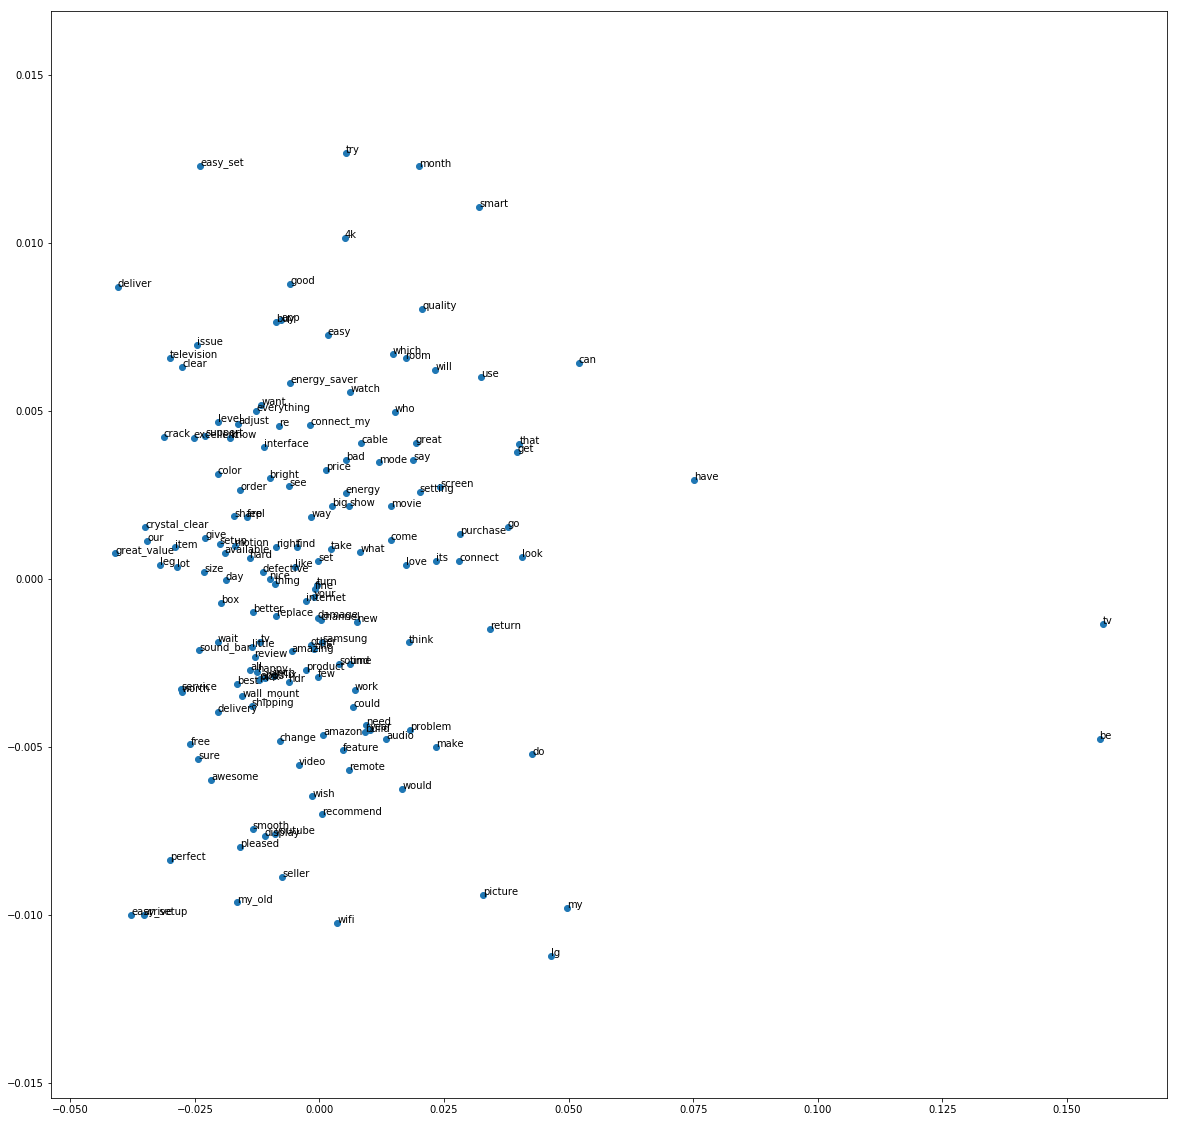

In [32]:

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    ax.annotate(word, xy=(result[i, 0], result[i, 1]))
#plt.show()
X.shape, result.shape

<IPython.core.display.Javascript object>


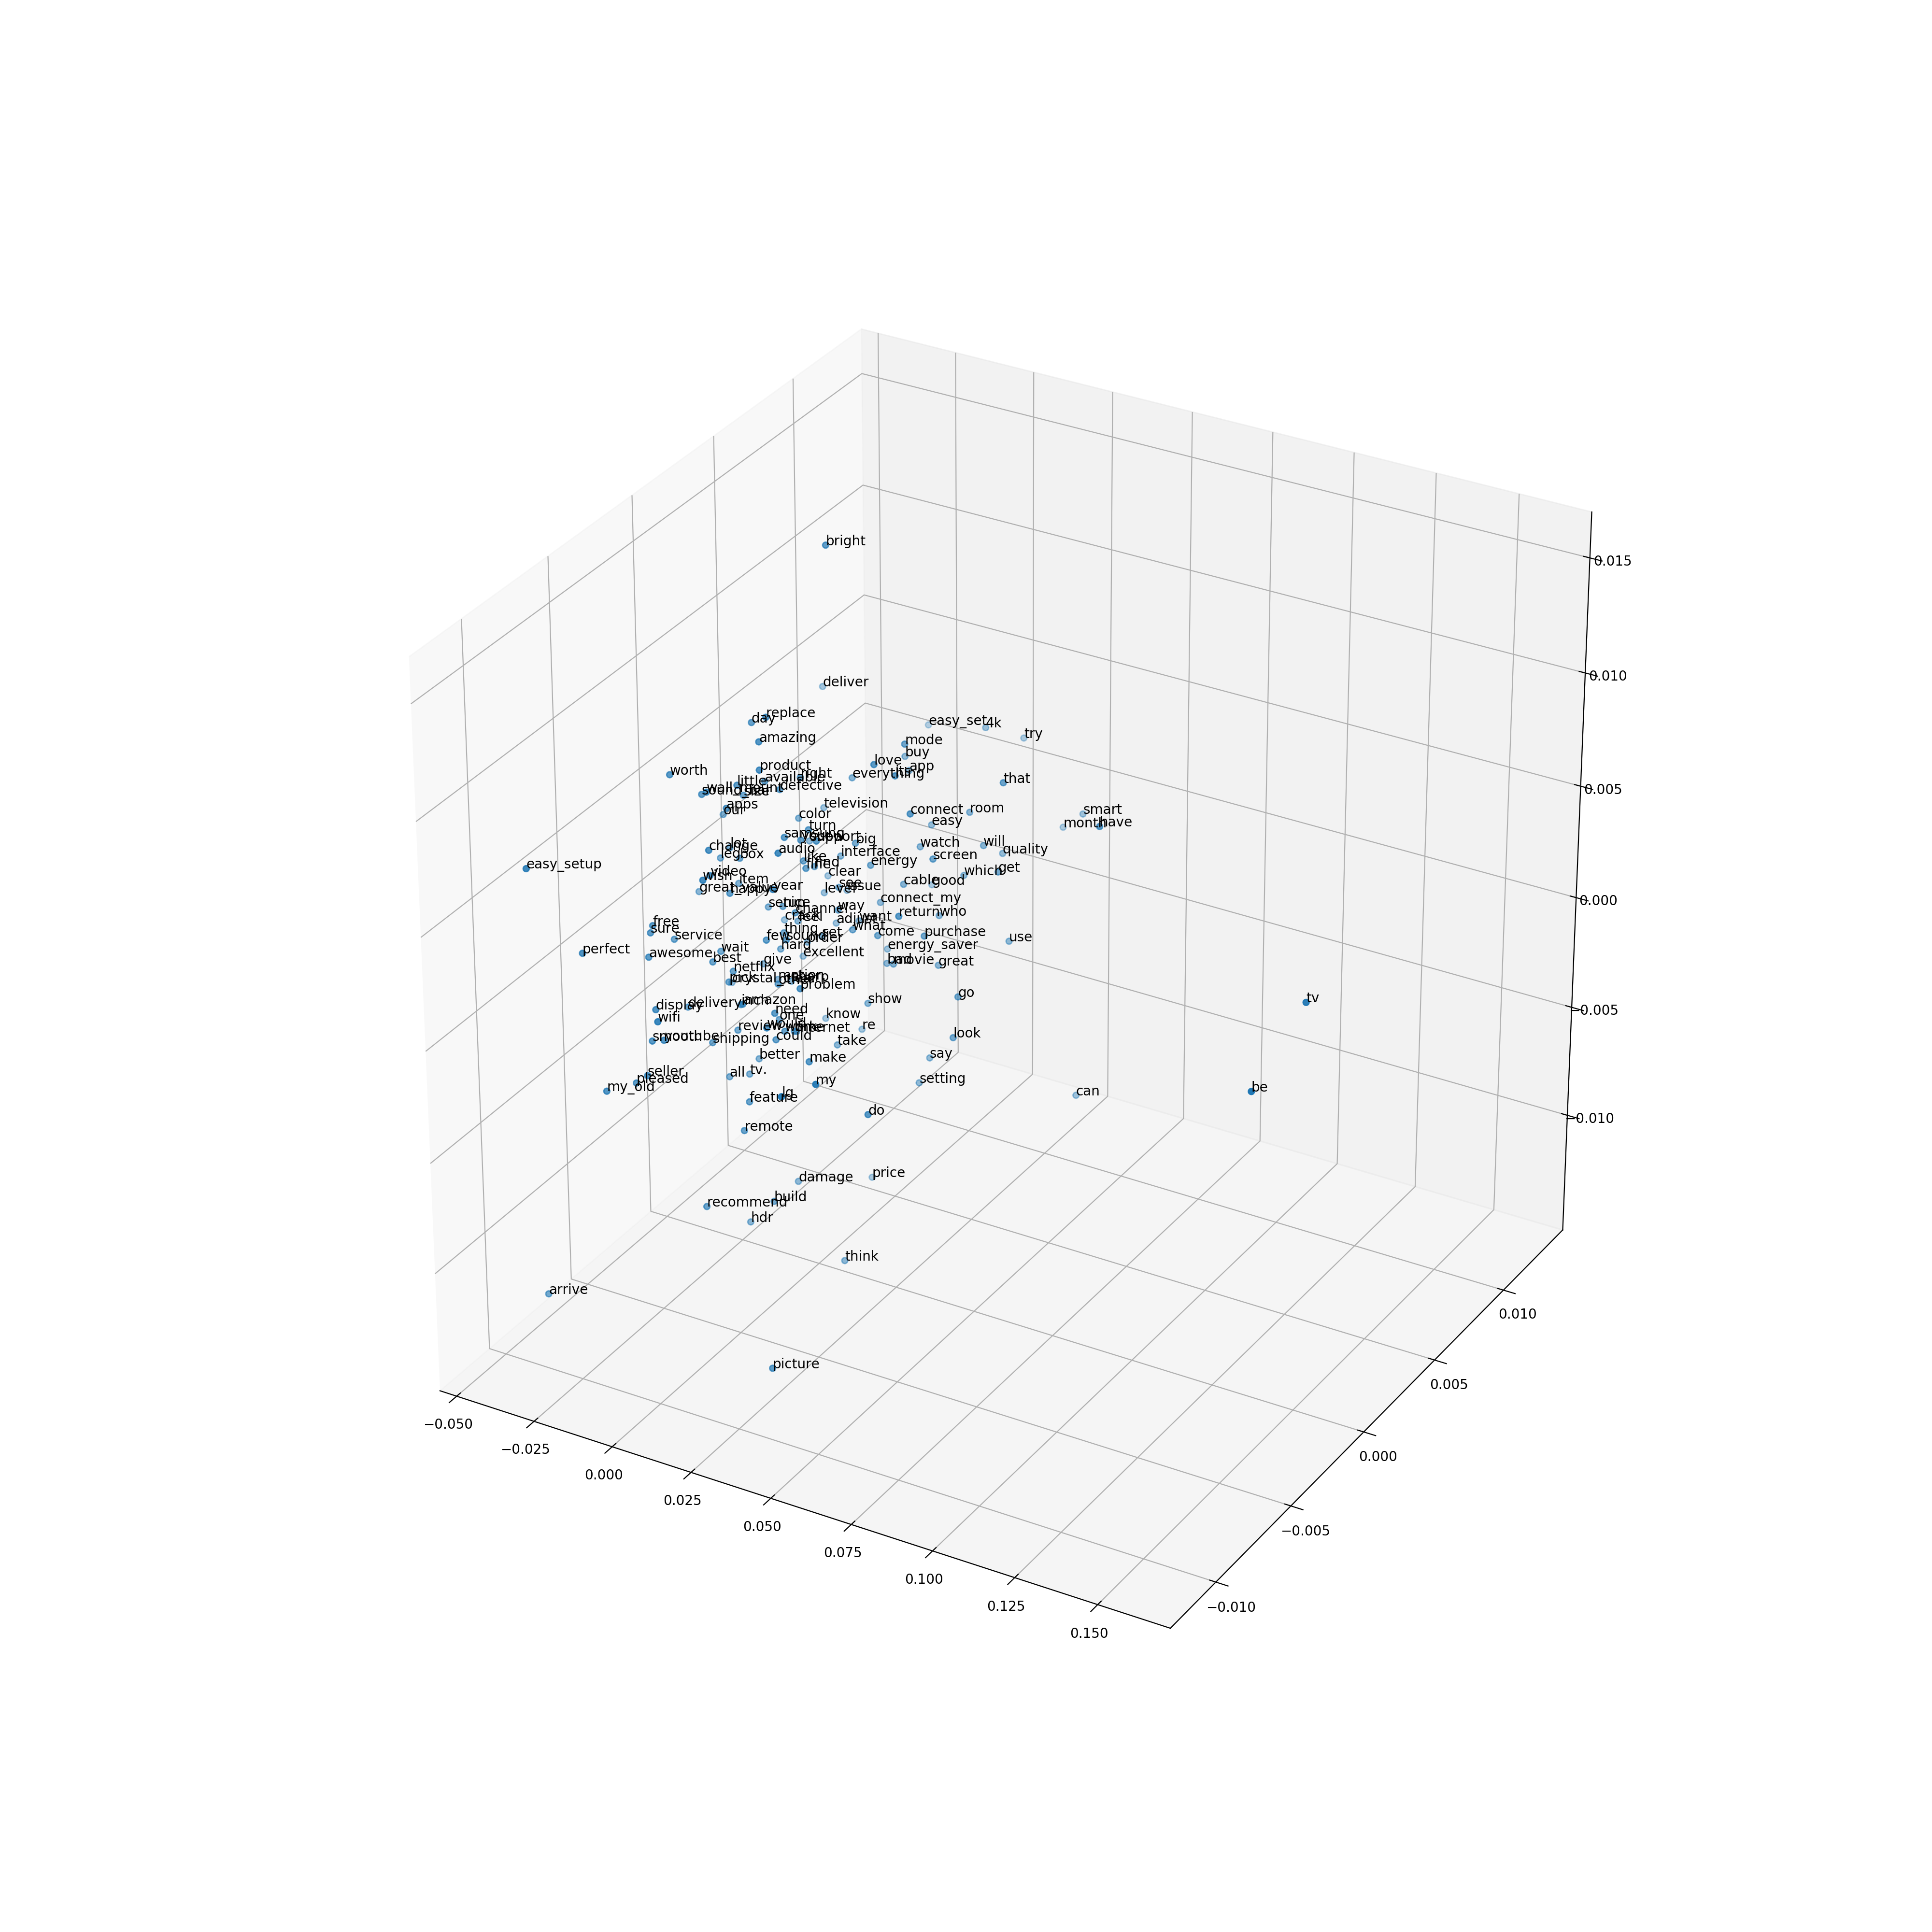

In [33]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

X = model[model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(X)
# create a scatter plot of the projection

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
words = list(model.wv.vocab)
ax.scatter(result[:, 0], result[:, 1], result[:, 2])
for i, word in enumerate(words):
    ax.text(result[i, 0], result[i, 1], result[i, 2], word)



In [34]:
def visualize(model, output_path):
    meta_file = "w2x_metadata.tsv"
    placeholder = np.zeros((len(model.wv.index2word), 100))

    with open(os.path.join(output_path,meta_file), 'wb') as file_metadata:
        for i, word in enumerate(model.wv.index2word):
            placeholder[i] = model[word]
            # temporary solution for https://github.com/tensorflow/tensorflow/issues/9094
            if word == '':
                print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
                file_metadata.write("{0}".format('<Empty Line>').encode('utf-8') + b'\n')
            else:
                file_metadata.write("{0}".format(word).encode('utf-8') + b'\n')

    # define the model without training
    sess = tf.InteractiveSession()

    embedding = tf.Variable(placeholder, trainable = False, name = 'w2x_metadata')
    tf.global_variables_initializer().run()

    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(output_path, sess.graph)

    # adding into projector
    config = projector.ProjectorConfig()
    embed = config.embeddings.add()
    embed.tensor_name = 'w2x_metadata'
    embed.metadata_path = meta_file

    # Specify the width and height of a single thumbnail.
    projector.visualize_embeddings(writer, config)
    saver.save(sess, os.path.join(output_path,'w2x_metadata.ckpt'))
    print('Run `tensorboard --logdir={0}` to run visualize result on tensorboard'.format(output_path))


In [35]:
visualize(model.wv, 'data/tensor/')

Run `tensorboard --logdir=data/tensor/` to run visualize result on tensorboard
